<a href="https://colab.research.google.com/github/project0fightttt-bit/ensenble/blob/main/%EC%95%99%EC%83%81%EB%B8%94_%EA%B5%B0%EC%A7%91_%EC%8B%9C%EA%B0%81%ED%99%94_%EC%98%88%EC%8B%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [11]:
netflix_global = '/content/all-weeks-global.xlsx'

In [12]:
global_excel_df = pd.read_excel(netflix_global)

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [13]:
from google.colab import drive
drive.mount('/content/drive')

# 파일 경로 예시 (드라이브 내 'Project' 폴더에 있다면)
title_basics = '/content/drive/MyDrive/앙상블(Ensemble) 프로젝트/project_data/title.basics.tsv.gz'
title_ratings = '/content/drive/MyDrive/앙상블(Ensemble) 프로젝트/project_data/title.ratings.tsv.gz'
# 그 후 read_csv에서 이 file_path를 사용하세요.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# --------------------------------------------------------------------------------
# 1. IMDb 데이터 로드 및 전처리 (메모리 절약을 위해 필요한 컬럼만 로드)
# --------------------------------------------------------------------------------
print("⏳ IMDb 데이터를 읽어오는 중입니다...")

# (1) title.basics 로드
df_basics = pd.read_csv(title_basics, sep='\t', compression='gzip',
                        usecols=['tconst', 'primaryTitle', 'startYear', 'genres', 'titleType'])

# 영화, TV시리즈만 남기기 (단편, 비디오게임 등 제외)
df_basics = df_basics[df_basics['titleType'].isin(['movie', 'tvSeries', 'tvMiniSeries'])].copy()

# (2) title.ratings 로드
df_ratings = pd.read_csv(title_ratings, sep='\t', compression='gzip',
                         usecols=['tconst', 'averageRating', 'numVotes'])

# (3) 두 데이터 합치기 (tconst 기준)
imdb_combined = pd.merge(df_basics, df_ratings, on='tconst', how='inner')

# (4) 제목 전처리 함수 (넷플릭스 데이터와 매칭하기 위함)
def clean_title(text):
    if pd.isna(text): return ""
    return re.sub(r'[^a-zA-Z0-9가-힣]', '', str(text).lower())

imdb_combined['title_cleaned'] = imdb_combined['primaryTitle'].apply(clean_title)
global_excel_df['title_cleaned'] = global_excel_df['show_title'].apply(clean_title)

print("✅ IMDb 데이터 준비 완료!")

# --------------------------------------------------------------------------------
# 2. 넷플릭스(원본) + IMDb 병합
# --------------------------------------------------------------------------------
# 넷플릭스 데이터(global_excel_df)를 기준으로 IMDb 정보를 붙입니다.
df_merged = pd.merge(global_excel_df,
                     imdb_combined[['title_cleaned', 'averageRating', 'numVotes', 'startYear', 'genres']],
                     on='title_cleaned',
                     how='left')

# 연도 정보 숫자 변환
df_merged['release_year'] = pd.to_numeric(df_merged['startYear'], errors='coerce')

# 구글 트렌드 컬럼이 아직 없으므로 0으로 생성 (추후 데이터 업데이트 필요)
if 'google_trend' not in df_merged.columns:
    df_merged['google_trend'] = 0

# --------------------------------------------------------------------------------
# 3. 작품별 집계 (Aggregation) - Spike형 분석의 핵심
# --------------------------------------------------------------------------------
# 모든 주차 기록 중 '최고치(Max)'를 뽑아 작품당 1줄로 만듭니다.
spike_df = df_merged.groupby('show_title').agg({
    'weekly_views': 'max',          # Max Views
    'weekly_hours_viewed': 'max',   # Max Hours (Views 결측치 보완용)
    'averageRating': 'first',       # 평점
    'numVotes': 'first',            # 투표수
    'google_trend': 'max',          # 검색량
    'genres': 'first',              # 장르
    'release_year': 'first'         # 출시연도
}).reset_index()

# 컬럼명 변경
spike_df.rename(columns={'weekly_views': 'max_views', 'weekly_hours_viewed': 'max_hours'}, inplace=True)

# --------------------------------------------------------------------------------
# 4. 결측치 처리 & 스케일링 & 점수 산출
# --------------------------------------------------------------------------------
def min_max_scale(series):
    if series.max() == series.min(): return 0
    return (series - series.min()) / (series.max() - series.min())

# (1) Views와 Hours 각각 스케일링 후 하이브리드 적용
spike_df['scaled_views_raw'] = min_max_scale(spike_df['max_views'])
spike_df['scaled_hours_raw'] = min_max_scale(spike_df['max_hours'])
# Views가 없으면(NaN) Hours 점수로 대체
spike_df['scaled_views'] = spike_df['scaled_views_raw'].fillna(spike_df['scaled_hours_raw'])

# (2) IMDb 스케일링 (투표수는 로그 변환)
spike_df['log_votes'] = np.log1p(spike_df['numVotes'].fillna(0))
spike_df['scaled_votes'] = min_max_scale(spike_df['log_votes'])
spike_df['scaled_rating'] = min_max_scale(spike_df['averageRating'].fillna(0))

# IMDb 복합 점수: 별점(50%) + 투표수(50%)
spike_df['scaled_imdb_composite'] = (spike_df['scaled_rating'] * 0.5) + (spike_df['scaled_votes'] * 0.5)

# (3) 구글 트렌드 스케일링
spike_df['scaled_trend'] = min_max_scale(spike_df['google_trend'].fillna(0))

# (4) 최종 Spike Score 산출 (가중치 적용)
# 가중치: Views(0.5) + Trend(0.3) + IMDb(0.2)
spike_df['spike_score'] = (
    (spike_df['scaled_views'] * 0.5) +
    (spike_df['scaled_trend'] * 0.3) +
    (spike_df['scaled_imdb_composite'] * 0.2)
) * 100

# --------------------------------------------------------------------------------
# 5. 결과 확인
# --------------------------------------------------------------------------------
spike_df = spike_df.sort_values('spike_score', ascending=False).reset_index(drop=True)

print(f"🔥 최종 Spike 데이터프레임 생성 완료!")
print(f"📊 총 작품 수: {len(spike_df)}개")
display(spike_df[['show_title', 'max_views', 'max_hours', 'spike_score', 'release_year']].head(10))

⏳ IMDb 데이터를 읽어오는 중입니다...
✅ IMDb 데이터 준비 완료!
🔥 최종 Spike 데이터프레임 생성 완료!
📊 총 작품 수: 3067개


,show_title,max_views,max_hours,spike_score,release_year
0,Squid Game,68000000.0,571760000,67.821461,2021.0
1,Stranger Things,59600000.0,335010000,57.432547,2008.0
2,Wednesday,50000000.0,411290000,54.285250,2022.0
3,Damsel,50800000.0,93200000,51.852981,2024.0
4,STRAW,48900000.0,88000000,49.935477,2025.0
5,Carry-On,55100000.0,110200000,49.760656,2022.0
6,Bridgerton,45100000.0,251740000,49.553041,2020.0
7,Happy Gilmore 2,46700000.0,91900000,48.786076,2025.0
8,Leave the World Behind,44900000.0,106200000,48.288656,2023.0
9,The Rip,41600000.0,78300000,45.598565,2026.0


In [15]:
global_excel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   week                        9600 non-null   object 
 1   category                    9600 non-null   object 
 2   weekly_rank                 9600 non-null   int64  
 3   show_title                  9600 non-null   object 
 4   season_title                4652 non-null   object 
 5   weekly_hours_viewed         9600 non-null   int64  
 6   runtime                     5520 non-null   float64
 7   weekly_views                5520 non-null   float64
 8   cumulative_weeks_in_top_10  9600 non-null   int64  
 9   title_cleaned               9600 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 750.1+ KB


In [16]:
spike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3067 entries, 0 to 3066
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   show_title             3067 non-null   object 
 1   max_views              1969 non-null   float64
 2   max_hours              3067 non-null   int64  
 3   averageRating          2795 non-null   float64
 4   numVotes               2795 non-null   float64
 5   google_trend           3067 non-null   int64  
 6   genres                 2795 non-null   object 
 7   release_year           2795 non-null   float64
 8   scaled_views_raw       1969 non-null   float64
 9   scaled_hours_raw       3067 non-null   float64
 10  scaled_views           3067 non-null   float64
 11  log_votes              3067 non-null   float64
 12  scaled_votes           3067 non-null   float64
 13  scaled_rating          3067 non-null   float64
 14  scaled_imdb_composite  3067 non-null   float64
 15  scal

In [17]:
# 과제: max_views가 1969. 결측치 많음.

In [18]:
spike_df.head()

,show_title,max_views,max_hours,averageRating,numVotes,google_trend,genres,release_year,scaled_views_raw,scaled_hours_raw,scaled_views,log_votes,scaled_votes,scaled_rating,scaled_imdb_composite,scaled_trend,spike_score
0,Squid Game,68000000.0,571760000,7.9,744124.0,0,"Action,Crime,Drama",2021.0,1.000000,1.000000,1.000000,13.519964,0.932684,0.849462,0.891073,0,67.821461
1,Stranger Things,59600000.0,335010000,8.5,704.0,0,Sci-Fi,2008.0,0.875371,0.585347,0.875371,6.558198,0.452422,0.913978,0.683200,0,57.432547
2,Wednesday,50000000.0,411290000,8.0,488299.0,0,"Comedy,Crime,Fantasy",2022.0,0.732938,0.718947,0.732938,13.098685,0.903621,0.860215,0.881918,0,54.285250
3,Damsel,50800000.0,93200000,6.1,117493.0,0,"Action,Adventure,Fantasy",2024.0,0.744807,0.161833,0.744807,11.674143,0.805348,0.655914,0.730631,0,51.852981
4,STRAW,48900000.0,88000000,6.5,30159.0,0,"Drama,Thriller",2025.0,0.716617,0.152725,0.716617,10.314272,0.711537,0.698925,0.705231,0,49.935477


In [19]:
spike_df.tail()

,show_title,max_views,max_hours,averageRating,numVotes,google_trend,genres,release_year,scaled_views_raw,scaled_hours_raw,scaled_views,log_votes,scaled_votes,scaled_rating,scaled_imdb_composite,scaled_trend,spike_score
3062,Doctor (Tamil),NaN,1530000,NaN,NaN,0,None,NaN,NaN,0.001279,0.001279,0.0,0.0,0.0,0.0,0,0.063927
3063,"Bua Pun, Beauty and the Blade",NaN,1430000,NaN,NaN,0,None,NaN,NaN,0.001103,0.001103,0.0,0.0,0.0,0.0,0,0.055170
3064,Kannai Nambathe,NaN,1400000,NaN,NaN,0,None,NaN,NaN,0.001051,0.001051,0.0,0.0,0.0,0.0,0,0.052543
3065,Thimmarusu,NaN,1220000,NaN,NaN,0,None,NaN,NaN,0.000736,0.000736,0.0,0.0,0.0,0.0,0,0.036780
3066,Pinkfong & Baby Shark's Space Adventure,600000.0,1120000,NaN,NaN,0,None,NaN,0.0,0.000560,0.000000,0.0,0.0,0.0,0.0,0,0.000000


In [24]:
# Google Trends 수집 및 spike_df 업데이트 코드

!pip install pytrends
import pandas as pd
import numpy as np
import os
import time
from datetime import timedelta
from pytrends.request import TrendReq
from tqdm import tqdm

# =========================
# 1) 수집 대상 추출 (최초 진출일 기준)
# =========================
# global_excel_df의 'week'를 날짜 형식으로 바꾸고, 작품별 최초 진출일만 남깁니다.
global_excel_df['week'] = pd.to_datetime(global_excel_df['week']).dt.normalize()

# 작품별로 가장 빠른(Oldest) 날짜 딱 하나만 추출하여 'pairs' 생성
pairs = global_excel_df.sort_values("week").drop_duplicates("show_title", keep="first")
pairs = pairs[["show_title", "week"]].reset_index(drop=True)

print(f"🎯 수집 대상 작품 수: {len(pairs)}개 (중복 없이 최초 진출일만 타겟팅)")

# =========================
# 2) Google Trends 설정 및 함수
# =========================
pytrends = TrendReq(hl="en-US", tz=0, retries=3, backoff_factor=1)

def trends_sum_14d(title: str, start: pd.Timestamp, geo: str = ""):
    """ 작품별 진출일 기준 14일간의 검색량 합산 """
    start = pd.Timestamp(start).normalize()
    end = start + timedelta(days=13)
    timeframe = f"{start.date()} {end.date()}"

    # 검색 정확도를 위해 "Netflix" 키워드 추가
    search_query = f"{title} Netflix"

    try:
        pytrends.build_payload([search_query], timeframe=timeframe, geo=geo)
        it = pytrends.interest_over_time()

        if it is None or it.empty or search_query not in it.columns:
            return 0.0

        if "isPartial" in it.columns:
            it = it.drop(columns=["isPartial"])

        return float(it[search_query].sum())
    except Exception as e:
        # 429 에러(Too Many Requests) 시 None 반환하여 나중에 재시도 유도
        return None

# =========================
# 3) 수집 루프 및 체크포인트 (spike_df에 반영하기 전 단계)
# =========================
CHECKPOINT = "spike_trend_results.csv"
SLEEP_SEC = 2.0  # 차단 방지를 위해 2초 권장
out = []
cache = {}

# 기존 작업물 불러오기 (이어서 하기)
if os.path.exists(CHECKPOINT):
    prev = pd.read_csv(CHECKPOINT)
    cache = dict(zip(prev['show_title'], prev['trend_sum_14d']))
    print(f"Loaded {len(cache)} existing results from checkpoint.")

for i, row in enumerate(tqdm(pairs.itertuples(index=False), total=len(pairs)), start=1):
    title, week = row.show_title, row.week

    if title in cache and pd.notnull(cache[title]):
        out.append(cache[title])
        continue

    time.sleep(SLEEP_SEC)
    val = trends_sum_14d(title, week)

    # 50개마다 좀 더 긴 휴식 (안전 장치)
    if i % 50 == 0:
        time.sleep(10)

    out.append(val)
    cache[title] = val

    # 100개마다 파일 저장
    if i % 100 == 0:
        temp_save = pairs.iloc[:i].copy()
        temp_save['trend_sum_14d'] = out
        temp_save.to_csv(CHECKPOINT, index=False)

# 최종 결과 저장
pairs["trend_sum_14d"] = out
pairs.to_csv(CHECKPOINT, index=False)

# =========================
# 4) 최종 spike_df에 결과 Merge
# =========================
# 이제 수집된 트렌드 점수를 우리의 메인 결과물인 spike_df에 합칩니다.
if 'trend_sum_14d' in spike_df.columns:
    spike_df = spike_df.drop(columns=['trend_sum_14d']) # 기존 컬럼 있으면 삭제

spike_df = pd.merge(spike_df, pairs[['show_title', 'trend_sum_14d']],
                    on='show_title', how='left')

print("✅ 모든 구글 트렌드 데이터가 spike_df에 통합되었습니다!")
display(spike_df[['show_title', 'spike_score', 'trend_sum_14d']].head(10))

🎯 수집 대상 작품 수: 3067개 (중복 없이 최초 진출일만 타겟팅)


100%|██████████| 3067/3067 [1:52:29<00:00,  2.20s/it]

✅ 모든 구글 트렌드 데이터가 spike_df에 통합되었습니다!


,show_title,spike_score,trend_sum_14d
0,Squid Game,67.821461,None
1,Stranger Things,57.432547,None
2,Wednesday,54.285250,None
3,Damsel,51.852981,None
4,STRAW,49.935477,None
5,Carry-On,49.760656,None
6,Bridgerton,49.553041,None
7,Happy Gilmore 2,48.786076,None
8,Leave the World Behind,48.288656,None
9,The Rip,45.598565,None


In [ ]:
27500000 /

### 군집별 평균 특성 (Cluster Centroids) ###
   Cluster     V_first      Weeks    T_peak  Count       Predicted_Type
0        0  488.726305   3.088796  1.519490     50  Type A (유사: 원히트 드롭)
1        1  105.358273  10.422824  5.896722     30  Type B (유사: 슬로우 버너)
2        2  407.591242  12.213359  1.962167     40     Type C (유사: 스테디)

### 원본 데이터 샘플 ###
      V_first     Weeks    T_peak   Actual_Type  Cluster
0  524.835708  3.486126  1.000000  One-Hit Drop        0
1  493.086785  2.422377  1.289677  One-Hit Drop        0
2  532.384427  1.984617  1.328643  One-Hit Drop        0
3  576.151493  3.917514  1.098861  One-Hit Drop        0
4  488.292331  4.546499  1.419357  One-Hit Drop        0


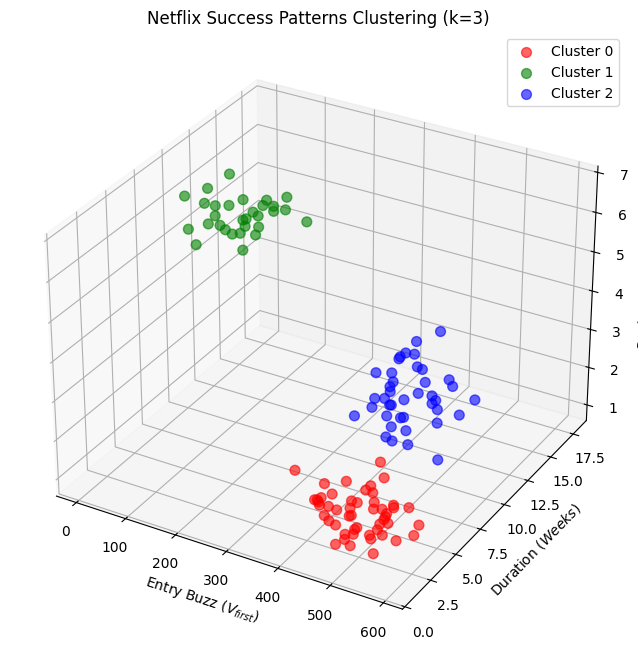

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# 1. 가상의 데이터 생성 (실제 데이터를 사용할 때는 pd.read_csv 등으로 불러오세요)
# V_first: 진입 화제성 (단위: 만 뷰 가정), Weeks: 지속 기간, T_peak: 피크 시점(주차)
data_config = {
    'One-Hit Drop': {'n': 50, 'v_mean': 500, 'w_mean': 3, 't_mean': 1.5}, # 폭죽형: 높은 초반, 짧은 기간, 빠른 피크
    'Steady':       {'n': 40, 'v_mean': 400, 'w_mean': 12, 't_mean': 2.0}, # 명예의 전당: 높은 초반, 긴 기간, 빠른 피크
    'Slow Burner':  {'n': 30, 'v_mean': 100, 'w_mean': 10, 't_mean': 6.0}  # 역주행: 낮은 초반, 긴 기간, 늦은 피크
}

np.random.seed(42)
df_list = []
for label, config in data_config.items():
    v = np.random.normal(config['v_mean'], 50, config['n']) # 표준편차 부여
    w = np.random.normal(config['w_mean'], 1.5, config['n'])
    t = np.random.normal(config['t_mean'], 0.5, config['n'])

    # 데이터 노이즈 및 범위 보정 (음수 방지 등)
    w = np.maximum(w, 1)
    t = np.maximum(t, 1)

    temp_df = pd.DataFrame({'V_first': v, 'Weeks': w, 'T_peak': t})
    temp_df['Actual_Type'] = label # 나중에 비교를 위해 실제 정답 달아둠
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)

# 2. 데이터 전처리 (스케일링)
# V_first는 단위가 크고, Weeks/T_peak는 단위가 작으므로 정규화(StandardScaler)가 필수입니다.
features = ['V_first', 'Weeks', 'T_peak']
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

# 3. K-Means 군집화 수행 (k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# 4. 결과 분석: 각 군집별 평균 특성 확인
cluster_summary = df.groupby('Cluster')[features].mean().reset_index()
cluster_summary['Count'] = df.groupby('Cluster')['Cluster'].count().values

# 해석을 돕기 위해 군집별 이름 매핑 (평균값을 보고 로직으로 자동 할당해 봅니다)
def name_cluster(row):
    # 간단한 규칙 기반 매핑 (실제 데이터에 따라 조정 필요)
    if row['Weeks'] < 5 and row['V_first'] > row['Weeks']*20: # 기간 짧고 화제성 높음
        return "Type A (유사: 원히트 드롭)"
    elif row['T_peak'] > 4: # 피크가 늦음
        return "Type B (유사: 슬로우 버너)"
    else:
        return "Type C (유사: 스테디)"

cluster_summary['Predicted_Type'] = cluster_summary.apply(name_cluster, axis=1)

# 5. 3D 시각화
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b']
for i in range(3):
    cluster_data = df[df['Cluster'] == i]
    ax.scatter(cluster_data['V_first'], cluster_data['Weeks'], cluster_data['T_peak'],
               c=colors[i], label=f'Cluster {i}', s=50, alpha=0.6)

ax.set_xlabel('Entry Buzz ($V_{first}$)')
ax.set_ylabel('Duration ($Weeks$)')
ax.set_zlabel('Peak Time ($T_{peak}$)')
ax.set_title('Netflix Success Patterns Clustering (k=3)')
plt.legend()

# 결과 출력
print("### 군집별 평균 특성 (Cluster Centroids) ###")
print(cluster_summary)
print("\n### 원본 데이터 샘플 ###")
print(df.head())

plt.savefig('netflix_clustering_3d.png')

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. 데이터 로드 (선생님의 파일 경로)
file_path = '/content/all-weeks-global.xlsx'
df = pd.read_excel(file_path)

# 2. 데이터 전처리: 우리가 원하는 3가지 지표 만들기
# 날짜 형식 변환
df['week'] = pd.to_datetime(df['week'])

# 영화와 TV쇼를 구분하기 위해 고유 ID 생성 (TV는 시즌별로 구분)
# season_title이 있으면 그것을 쓰고, 없으면 show_title을 씁니다.
df['unique_id'] = df.apply(lambda x: x['season_title'] if pd.notnull(x['season_title']) and x['season_title'] != 'N/A' else x['show_title'], axis=1)

# 작품별로 그룹화하여 지표 계산
grouped = df.groupby('unique_id')

data_list = []

for name, group in grouped:
    group = group.sort_values('week') # 날짜순 정렬

    # (1) 진입 화제성 (V_first): 차트 진입 첫 주의 시청 뷰 수
    # 주의: 데이터셋에 처음 등장한 날을 기준으로 함
    v_first = group.iloc[0]['weekly_views']

    # (2) 지속 기간 (Weeks): 누적 Top 10 진입 주차의 최댓값
    weeks = group['cumulative_weeks_in_top_10'].max()

    # (3) 피크 시점 (T_peak): 뷰 수가 가장 높았던 주차가 진입 후 몇 주째인지
    # 뷰가 가장 높은 행 찾기
    peak_row = group.loc[group['weekly_views'].idxmax()]

    # 피크 날짜 - 진입 날짜 (주 단위 계산)
    # +1을 해주는 이유는 첫 주에 피크면 1주차로 표시하기 위함
    t_peak = ((peak_row['week'] - group.iloc[0]['week']).days / 7) + 1

    data_list.append({
        'Title': name,
        'V_first': v_first,
        'Weeks': weeks,
        'T_peak': t_peak
    })

# 분석용 데이터프레임 생성
df_analysis = pd.DataFrame(data_list)

# 이상치 제거 (선택 사항: 데이터가 너무 적거나 튀는 경우 제외할 수 있음)
# 여기서는 그대로 진행합니다.

# 3. K-Means 군집화
features = ['V_first', 'Weeks', 'T_peak']

# 스케일링 (단위 보정)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_analysis[features])

# 군집화 (k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_analysis['Cluster'] = kmeans.fit_predict(df_scaled)

# 4. 결과 해석 및 라벨링
cluster_summary = df_analysis.groupby('Cluster')[features].mean().reset_index()
cluster_summary['Count'] = df_analysis.groupby('Cluster')['Cluster'].count().values

def name_cluster(row):
    # 평균값을 기준으로 유형 정의 (상대적 기준)
    # T_peak가 가장 늦은 그룹 -> 슬로우 버너
    # Weeks가 가장 긴 그룹 -> 스테디
    # 나머지 -> 원히트 드롭 (보통 V_first는 높고 Weeks 짧음)

    # 이 로직은 실행 후 나온 평균값을 보고 수정이 필요할 수 있습니다.
    # 여기서는 일반적인 로직으로 자동 할당을 시도합니다.
    if row['T_peak'] >= 3.0:
        return "Slow Burner (역주행형)"
    elif row['Weeks'] > 5 and row['V_first'] > 5000000: # 기준값은 예시
        return "Steady (명예의 전당형)"
    else:
        return "One-Hit Drop (폭죽형/기타)"

# 자동 라벨링 적용 (결과가 이상하면 위 함수 조건을 조정하세요)
cluster_summary['Predicted_Type'] = cluster_summary.apply(name_cluster, axis=1)

print("### 군집별 평균 특성 ###")
print(cluster_summary)

# 5. 3D 시각화
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b']
for i in range(3):
    sub_data = df_analysis[df_analysis['Cluster'] == i]
    # 중심점 정보로 범례 이름 가져오기
    label_name = cluster_summary.loc[i, 'Predicted_Type']

    ax.scatter(sub_data['V_first'], sub_data['Weeks'], sub_data['T_peak'],
               c=colors[i], label=f'Cluster {i}: {label_name}', s=30, alpha=0.6)

ax.set_xlabel('Entry Views (V_first)')
ax.set_ylabel('Duration (Weeks)')
ax.set_zlabel('Peak Time (T_peak)')
ax.set_title('Netflix Success Patterns with Real Data')
plt.legend()
plt.show()

# 각 유형별 대표 작품 5개씩 출력해보기
for i in range(3):
    type_name = cluster_summary.loc[i, 'Predicted_Type']
    print(f"\n--- Cluster {i}: {type_name} 대표 작품 ---")
    print(df_analysis[df_analysis['Cluster'] == i].sort_values('Weeks', ascending=False)['Title'].head(5).values)

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/tmp/ipython-input-3758594365.py:36: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  peak_row = group.loc[group['weekly_views'].idxmax()]


KeyError: nan

In [27]:
이 오류(KeyError: nan)는 데이터셋의 weekly_views(주간 시청 시간/뷰 수) 컬럼에 빈 값(NaN)이 포함되어 있거나, 특정 작품의 모든 주차 데이터가 비어 있어서 idxmax() 함수가 최댓값의 위치를 찾지 못하고 nan을 반환했기 때문에 발생합니다.

쉽게 말해, **"시청 기록이 없는 유령 데이터"**가 섞여 있어서 코드 계산 중에 에러가 난 것입니다.

이를 해결하기 위해 데이터를 불러온 직후에 빈 값을 제거하는 전처리 코드를 추가한 수정된 버전을 드립니다.

수정된 코드 (복사해서 실행하세요)
Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. 데이터 로드
file_path = '/content/all-weeks-global.xlsx'
df = pd.read_excel(file_path)

# [수정 1] 데이터 전처리: 결측치 및 데이터 타입 정리 (에러 방지 핵심)
# weekly_views가 비어있는 행은 분석에서 제외합니다.
df = df.dropna(subset=['weekly_views'])

# weekly_views가 혹시 문자로 되어있을 경우를 대비해 숫자로 강제 변환
df['weekly_views'] = pd.to_numeric(df['weekly_views'], errors='coerce')
df = df.dropna(subset=['weekly_views']) # 변환 후 생긴 NaN도 다시 제거

# 날짜 형식 변환
df['week'] = pd.to_datetime(df['week'])

# 영화와 TV쇼 구분 (season_title 활용)
df['unique_id'] = df.apply(lambda x: x['season_title'] if pd.notnull(x['season_title']) and x['season_title'] != 'N/A' else x['show_title'], axis=1)

# 2. 지표 계산
grouped = df.groupby('unique_id')
data_list = []

for name, group in grouped:
    # 데이터가 너무 적은 경우(예: 기록이 1개뿐인데 0인 경우) 건너뛰기
    if len(group) < 1:
        continue

    group = group.sort_values('week') # 날짜순 정렬

    try:
        # (1) 진입 화제성 (V_first): 첫 주 시청 뷰 수
        v_first = group.iloc[0]['weekly_views']

        # (2) 지속 기간 (Weeks): 누적 Top 10 진입 주차의 최댓값
        # 만약 컬럼이 없거나 비어있으면 그룹의 행 개수(len)로 대체
        if 'cumulative_weeks_in_top_10' in group.columns and not group['cumulative_weeks_in_top_10'].isnull().all():
            weeks = group['cumulative_weeks_in_top_10'].max()
        else:
            weeks = len(group)

        # (3) 피크 시점 (T_peak): 피크 주차 - 진입 주차
        # idxmax()가 안전하게 작동하도록 보장된 상태
        peak_idx = group['weekly_views'].idxmax()
        peak_row = df.loc[peak_idx] # 원본 인덱스 사용하여 접근

        t_peak = ((peak_row['week'] - group.iloc[0]['week']).days / 7) + 1

        # 이상치 방지 (음수나 0이 나오면 1로 보정)
        t_peak = max(1.0, t_peak)

        data_list.append({
            'Title': name,
            'V_first': v_first,
            'Weeks': weeks,
            'T_peak': t_peak
        })

    except Exception as e:
        # 특정 작품에서 에러가 나면 건너뛰고 계속 진행
        print(f"Skipping {name}: {e}")
        continue

# 분석용 데이터프레임 생성
df_analysis = pd.DataFrame(data_list)
print(f"분석 대상 작품 수: {len(df_analysis)}개")

# 3. K-Means 군집화
if len(df_analysis) > 3: # 데이터가 충분할 때만 실행
    features = ['V_first', 'Weeks', 'T_peak']
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_analysis[features])

    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df_analysis['Cluster'] = kmeans.fit_predict(df_scaled)

    # 4. 결과 해석 및 라벨링
    cluster_summary = df_analysis.groupby('Cluster')[features].mean().reset_index()
    cluster_summary['Count'] = df_analysis.groupby('Cluster')['Cluster'].count().values

    print("\n### 군집별 평균 특성 ###")
    print(cluster_summary)

    # 5. 3D 시각화
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    colors = ['r', 'g', 'b']
    labels = ['Type A', 'Type B', 'Type C'] # 임시 라벨

    for i in range(3):
        sub_data = df_analysis[df_analysis['Cluster'] == i]
        ax.scatter(sub_data['V_first'], sub_data['Weeks'], sub_data['T_peak'],
                   c=colors[i], label=f'Cluster {i}', s=30, alpha=0.6)

    ax.set_xlabel('Entry Views (V_first)')
    ax.set_ylabel('Duration (Weeks)')
    ax.set_zlabel('Peak Time (T_peak)')
    ax.set_title('Netflix Success Patterns')
    plt.legend()
    plt.show()

else:
    print("데이터가 너무 적어 군집화를 수행할 수 없습니다.")

SyntaxError: invalid syntax (ipython-input-3360235865.py, line 1)

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


분석 대상 작품 수: 2177개

### 군집별 평균 특성 (Cluster Centroids) ###
   Cluster       V_first     Weeks     T_peak  Count
0        0  3.594827e+06  2.243663   1.376099   1933
1        1  3.364000e+06  7.200000  77.600000     25
2        2  1.715982e+07  7.584475   2.132420    219


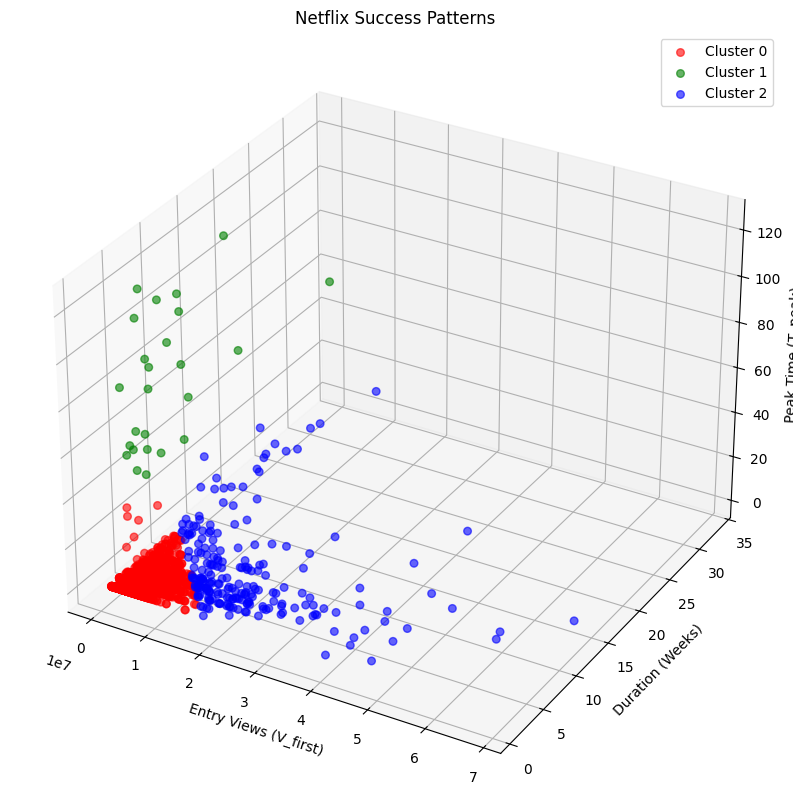

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. 데이터 로드 (경로 확인 필수)
file_path = '/content/all-weeks-global.xlsx'
df = pd.read_excel(file_path)

# 2. 데이터 전처리 (에러 방지 로직 포함)
# 빈 데이터 제거
df = df.dropna(subset=['weekly_views'])
df['weekly_views'] = pd.to_numeric(df['weekly_views'], errors='coerce')
df = df.dropna(subset=['weekly_views'])

# 날짜 변환
df['week'] = pd.to_datetime(df['week'])

# 영화/TV 구분 (season_title 활용)
df['unique_id'] = df.apply(lambda x: x['season_title'] if pd.notnull(x['season_title']) and x['season_title'] != 'N/A' else x['show_title'], axis=1)

# 3. 지표 계산 및 데이터프레임 생성
grouped = df.groupby('unique_id')
data_list = []

for name, group in grouped:
    # 데이터가 너무 적으면(행이 없으면) 패스
    if len(group) < 1:
        continue

    group = group.sort_values('week') # 날짜순 정렬

    try:
        # (1) 진입 화제성 (V_first)
        v_first = group.iloc[0]['weekly_views']

        # (2) 지속 기간 (Weeks)
        if 'cumulative_weeks_in_top_10' in group.columns:
            weeks = group['cumulative_weeks_in_top_10'].max()
            if pd.isna(weeks): # 만약 NaN이면 행 개수로 대체
                weeks = len(group)
        else:
            weeks = len(group)

        # (3) 피크 시점 (T_peak)
        peak_idx = group['weekly_views'].idxmax()
        peak_row = df.loc[peak_idx]

        # (피크 날짜 - 첫 진입 날짜) / 7일 + 1
        t_peak = ((peak_row['week'] - group.iloc[0]['week']).days / 7) + 1
        t_peak = max(1.0, t_peak) # 최소 1주로 보정

        data_list.append({
            'Title': name,
            'V_first': v_first,
            'Weeks': weeks,
            'T_peak': t_peak
        })

    except Exception as e:
        continue

# 분석용 데이터프레임
df_analysis = pd.DataFrame(data_list)
print(f"분석 대상 작품 수: {len(df_analysis)}개")

# 4. K-Means 군집화 및 시각화
if len(df_analysis) > 10:
    # 스케일링
    features = ['V_first', 'Weeks', 'T_peak']
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_analysis[features])

    # 군집화 (k=3)
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df_analysis['Cluster'] = kmeans.fit_predict(df_scaled)

    # 결과 요약 출력
    cluster_summary = df_analysis.groupby('Cluster')[features].mean().reset_index()
    cluster_summary['Count'] = df_analysis.groupby('Cluster')['Cluster'].count().values

    print("\n### 군집별 평균 특성 (Cluster Centroids) ###")
    print(cluster_summary)

    # 3D 시각화
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    colors = ['r', 'g', 'b']
    for i in range(3):
        sub_data = df_analysis[df_analysis['Cluster'] == i]
        ax.scatter(sub_data['V_first'], sub_data['Weeks'], sub_data['T_peak'],
                   c=colors[i], label=f'Cluster {i}', s=30, alpha=0.6)

    ax.set_xlabel('Entry Views (V_first)')
    ax.set_ylabel('Duration (Weeks)')
    ax.set_zlabel('Peak Time (T_peak)')
    ax.set_title('Netflix Success Patterns')
    plt.legend()
    plt.show()

else:
    print("데이터가 부족하여 시각화할 수 없습니다.")

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


분석 대상 작품 수: 1364개

### 군집별 평균 특성 (보완된 모델) ###
   Cluster       V_first      Weeks     T_peak    Growth  Count  \
0        0  2.731345e+06   2.932741   1.779188  0.354597    788   
1        1  3.213333e+06  12.244444  46.733333  1.619995     45   
2        2  1.163277e+07   4.312618   1.410546  0.123002    531   

       Predicted_Type  
0  One-Hit Drop (폭죽형)  
1  Slow Burner (역주행형)  
2  One-Hit Drop (폭죽형)  


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51453 (\N{HANGUL SYLLABLE JUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/u

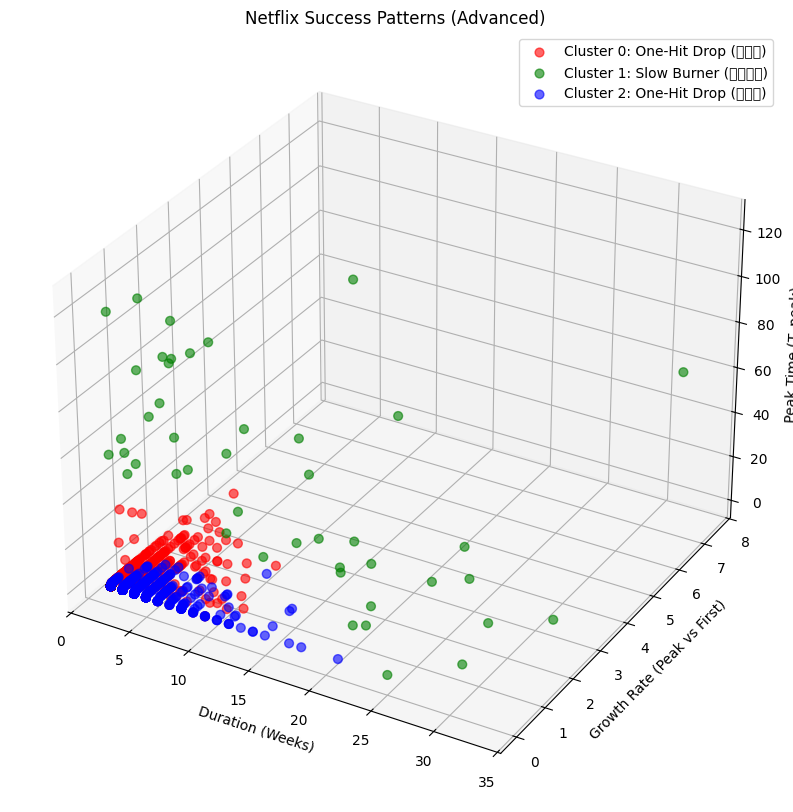


[각 유형별 대표 작품 예시]

>> One-Hit Drop (폭죽형) (Cluster 0)
- Unknown Number: The High School Catfish: (Weeks: 4, Growth: 2.06, Peak: 2.0주차)
- The Abyss: (Weeks: 7, Growth: 2.23, Peak: 2.0주차)
- Kingsman: The Secret Service: (Weeks: 3, Growth: 1.20, Peak: 2.0주차)

>> Slow Burner (역주행형) (Cluster 1)
- Squid Game: Season 1: (Weeks: 32, Growth: 7.50, Peak: 59.0주차)
- Baby Reindeer: Limited Series: (Weeks: 8, Growth: 7.46, Peak: 3.0주차)
- The Roast of Tom Brady: (Weeks: 3, Growth: 5.90, Peak: 2.0주차)

>> One-Hit Drop (폭죽형) (Cluster 2)
- Squid Game: Season 2: (Weeks: 14, Growth: 0.00, Peak: 1.0주차)
- Squid Game: Season 3: (Weeks: 9, Growth: 0.00, Peak: 1.0주차)
- Stranger Things 5: (Weeks: 10, Growth: 0.00, Peak: 1.0주차)


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. 데이터 로드
file_path = '/content/all-weeks-global.xlsx'
df = pd.read_excel(file_path)

# 데이터 전처리 (결측치 제거 및 타입 변환)
df = df.dropna(subset=['weekly_views'])
df['weekly_views'] = pd.to_numeric(df['weekly_views'], errors='coerce')
df['week'] = pd.to_datetime(df['week'])

# 영화/TV 구분 (season_title 활용)
df['unique_id'] = df.apply(lambda x: x['season_title'] if pd.notnull(x['season_title']) and x['season_title'] != 'N/A' else x['show_title'], axis=1)

# 2. 핵심 지표 계산 (보완된 로직 적용)
grouped = df.groupby('unique_id')
data_list = []

for name, group in grouped:
    if len(group) < 2: # 데이터가 2주 미만인 것은 추세를 알 수 없으므로 제외 (선택 사항)
        continue

    group = group.sort_values('week') # 날짜순 정렬

    try:
        # (1) 진입 화제성 (V_first)
        v_first = group.iloc[0]['weekly_views']

        # (2) 지속 기간 (Weeks)
        if 'cumulative_weeks_in_top_10' in group.columns:
            weeks = group['cumulative_weeks_in_top_10'].max()
            if pd.isna(weeks): weeks = len(group)
        else:
            weeks = len(group)

        # (3) 피크 시점 (T_peak) 및 성장률 (Growth) - **핵심 보완**
        peak_idx = group['weekly_views'].idxmax()
        peak_val = group.loc[peak_idx, 'weekly_views']
        peak_row = df.loc[peak_idx]

        # 진입 후 몇 주 뒤에 피크가 왔는가?
        t_peak = ((peak_row['week'] - group.iloc[0]['week']).days / 7) + 1
        t_peak = max(1.0, t_peak)

        # **성장률(Growth Rate)**: 첫 주 대비 얼마나 뷰가 늘었는가?
        # 양수면 역주행, 음수면 하락세
        growth = (peak_val - v_first) / v_first

        data_list.append({
            'Title': name,
            'V_first': v_first,
            'Weeks': weeks,
            'T_peak': t_peak,
            'Growth': growth # 이 변수가 '슬로우 버너' 식별의 핵심 키
        })

    except Exception as e:
        continue

# 분석용 데이터프레임
df_analysis = pd.DataFrame(data_list)
print(f"분석 대상 작품 수: {len(df_analysis)}개")

# 3. 데이터 변환 및 군집화
if len(df_analysis) > 10:
    # **로그 변환**: 뷰 수의 편차가 너무 크므로 Log를 취해 패턴 위주로 분석
    df_analysis['Log_V_first'] = np.log1p(df_analysis['V_first'])

    # 사용할 특성 선택: V_first 대신 Log_V_first 사용, Growth 추가
    features = ['Log_V_first', 'Weeks', 'T_peak', 'Growth']

    # 스케일링
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_analysis[features])

    # K-Means (k=3)
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=20) # n_init을 늘려 안정성 확보
    df_analysis['Cluster'] = kmeans.fit_predict(df_scaled)

    # 4. 결과 해석 및 라벨링
    # 원래 값 기준으로 평균 보기
    summary_cols = ['V_first', 'Weeks', 'T_peak', 'Growth']
    cluster_summary = df_analysis.groupby('Cluster')[summary_cols].mean().reset_index()
    cluster_summary['Count'] = df_analysis.groupby('Cluster')['Cluster'].count().values

    # 자동 라벨링 로직 (보완된 기준)
    def name_cluster_advanced(row):
        # 성장률(Growth)이 가장 높고 T_peak가 늦으면 -> 슬로우 버너
        if row['Growth'] > 0.5 or row['T_peak'] > 3.0:
            return "Slow Burner (역주행형)"
        # 지속 기간(Weeks)이 매우 길면 -> 스테디
        elif row['Weeks'] > 8:
            return "Steady (명예의 전당형)"
        # 나머지 -> 원히트 드롭
        else:
            return "One-Hit Drop (폭죽형)"

    cluster_summary['Predicted_Type'] = cluster_summary.apply(name_cluster_advanced, axis=1)

    print("\n### 군집별 평균 특성 (보완된 모델) ###")
    print(cluster_summary)

    # 5. 결과 시각화 (3D: X=Weeks, Y=Growth, Z=T_peak)
    # V_first는 색상 농도나 크기로 표현하지 않고 축에서 제외하여 패턴을 더 잘 보이게 함
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    colors = ['r', 'g', 'b']

    for i in range(3):
        sub_data = df_analysis[df_analysis['Cluster'] == i]
        label_name = cluster_summary.loc[i, 'Predicted_Type']

        # X: 지속 기간, Y: 성장률, Z: 피크 시점
        ax.scatter(sub_data['Weeks'], sub_data['Growth'], sub_data['T_peak'],
                   c=colors[i], label=f'Cluster {i}: {label_name}', s=40, alpha=0.6)

    ax.set_xlabel('Duration (Weeks)')
    ax.set_ylabel('Growth Rate (Peak vs First)')
    ax.set_zlabel('Peak Time (T_peak)')
    ax.set_title('Netflix Success Patterns (Advanced)')
    plt.legend()
    plt.show()

    # 각 유형별 대표 작품 확인
    print("\n[각 유형별 대표 작품 예시]")
    for i in range(3):
        c_type = cluster_summary.loc[i, 'Predicted_Type']
        print(f"\n>> {c_type} (Cluster {i})")
        # 해당 클러스터에서 대표적인(각 지표가 높은) 작품 3개
        if "Slow" in c_type:
            top_works = df_analysis[df_analysis['Cluster']==i].sort_values('Growth', ascending=False).head(3)
        elif "Steady" in c_type:
            top_works = df_analysis[df_analysis['Cluster']==i].sort_values('Weeks', ascending=False).head(3)
        else:
            top_works = df_analysis[df_analysis['Cluster']==i].sort_values('V_first', ascending=False).head(3)

        for _, row in top_works.iterrows():
            print(f"- {row['Title']}: (Weeks: {row['Weeks']:.0f}, Growth: {row['Growth']:.2f}, Peak: {row['T_peak']:.1f}주차)")

else:
    print("데이터 부족")


### 군집별 평균 특성 (수정된 라벨) ###
              V_first      Weeks     T_peak    Growth      Predicted_Type  \
Cluster                                                                     
0        2.731345e+06   2.932741   1.779188  0.354597  One-Hit Drop (폭죽형)   
1        3.213333e+06  12.244444  46.733333  1.619995  Slow Burner (역주행형)   
2        1.163277e+07   4.312618   1.410546  0.123002    Steady (명예의 전당형)   

         Count  
Cluster         
0          788  
1           45  
2          531  


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51453 (\N{HANGUL SYLLABLE JUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/u

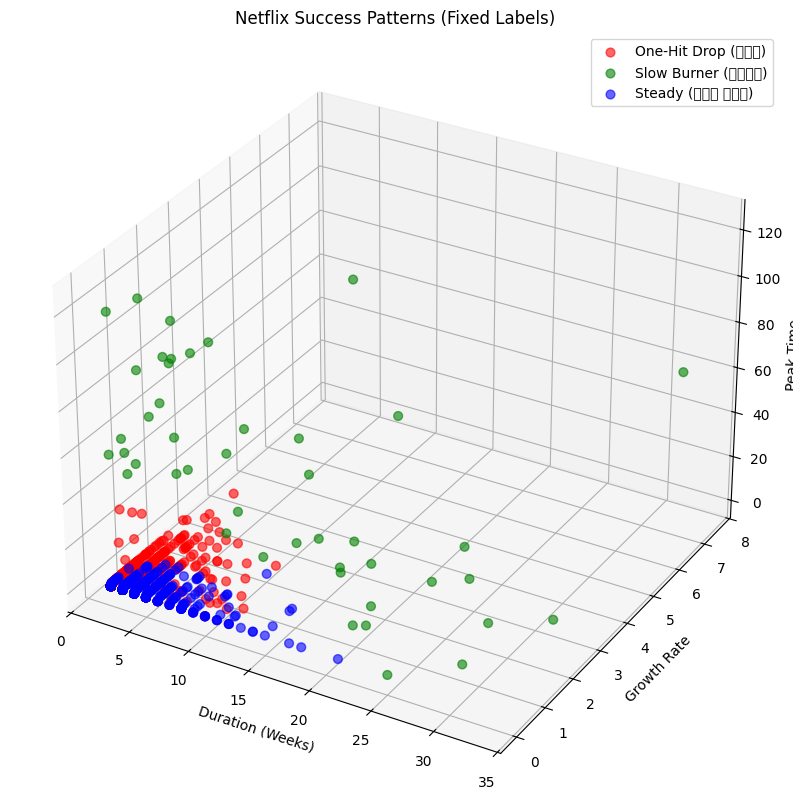


[각 유형별 대표 작품 예시 - 수정본]

>> One-Hit Drop (폭죽형)
- Unknown Number: The High School Catfish: (Weeks: 4, Growth: 2.06, Peak: 2.0주차)
- The Abyss: (Weeks: 7, Growth: 2.23, Peak: 2.0주차)
- Kingsman: The Secret Service: (Weeks: 3, Growth: 1.20, Peak: 2.0주차)
- Godzilla Minus One: (Weeks: 5, Growth: 1.44, Peak: 2.0주차)
- Mango: (Weeks: 3, Growth: 0.86, Peak: 2.0주차)

>> Slow Burner (역주행형)
- Squid Game: Season 1: (Weeks: 32, Growth: 7.50, Peak: 59.0주차)
- Baby Reindeer: Limited Series: (Weeks: 8, Growth: 7.46, Peak: 3.0주차)
- The Roast of Tom Brady: (Weeks: 3, Growth: 5.90, Peak: 2.0주차)
- Stranger Things: (Weeks: 22, Growth: 3.94, Peak: 5.0주차)
- The Super Mario Bros. Movie: (Weeks: 24, Growth: 3.26, Peak: 2.0주차)

>> Steady (명예의 전당형)
- Under Paris: (Weeks: 21, Growth: 0.00, Peak: 1.0주차)
- Through My Window: (Weeks: 18, Growth: 0.00, Peak: 1.0주차)
- Paw Patrol: The Movie: (Weeks: 17, Growth: 0.00, Peak: 1.0주차)
- Shrek: (Weeks: 15, Growth: 0.81, Peak: 2.0주차)
- Troll: (Weeks: 15, Growth: 0.89, Peak: 2.0주차)

In [30]:
# 기존 코드의 '4. 결과 해석 및 라벨링' 부분부터 아래 코드로 덮어쓰세요.

# 군집별 평균값 계산
summary_cols = ['V_first', 'Weeks', 'T_peak', 'Growth']
cluster_summary = df_analysis.groupby('Cluster')[summary_cols].mean()

# -------------------------------------------------------
# [수정된 로직] 절대 기준 대신 '상대적 순위'로 라벨 할당
# -------------------------------------------------------
labels = {}

# 1. Slow Burner (역주행형): 성장률(Growth)이 가장 높은 군집
slow_burner_idx = cluster_summary['Growth'].idxmax()
labels[slow_burner_idx] = "Slow Burner (역주행형)"

# 2. Steady (명예의 전당형): 남은 것 중 지속 기간(Weeks)이 가장 긴 군집
remaining_idxs = [i for i in range(3) if i != slow_burner_idx]
steady_idx = cluster_summary.loc[remaining_idxs, 'Weeks'].idxmax()
labels[steady_idx] = "Steady (명예의 전당형)"

# 3. One-Hit Drop (폭죽형): 나머지 하나
one_hit_idx = [i for i in range(3) if i not in [slow_burner_idx, steady_idx]][0]
labels[one_hit_idx] = "One-Hit Drop (폭죽형)"

# 데이터프레임에 이름 적용
df_analysis['Predicted_Type'] = df_analysis['Cluster'].map(labels)
cluster_summary['Predicted_Type'] = cluster_summary.index.map(labels)
cluster_summary['Count'] = df_analysis.groupby('Cluster')['Cluster'].count().values

print("\n### 군집별 평균 특성 (수정된 라벨) ###")
print(cluster_summary)

# -------------------------------------------------------
# 시각화 및 대표작 출력 (기존과 동일)
# -------------------------------------------------------
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b']

for i in range(3):
    sub_data = df_analysis[df_analysis['Cluster'] == i]
    label_name = labels[i]
    ax.scatter(sub_data['Weeks'], sub_data['Growth'], sub_data['T_peak'],
               c=colors[i], label=f'{label_name}', s=40, alpha=0.6)

ax.set_xlabel('Duration (Weeks)')
ax.set_ylabel('Growth Rate')
ax.set_zlabel('Peak Time')
ax.set_title('Netflix Success Patterns (Fixed Labels)')
plt.legend()
plt.show()

print("\n[각 유형별 대표 작품 예시 - 수정본]")
for i in range(3):
    c_type = labels[i]
    print(f"\n>> {c_type}")

    # 유형별 정렬 기준 다르게 적용
    if i == slow_burner_idx: # 역주행은 성장률 순
        top_works = df_analysis[df_analysis['Cluster']==i].sort_values('Growth', ascending=False).head(5)
    elif i == steady_idx:    # 스테디는 기간 순
        top_works = df_analysis[df_analysis['Cluster']==i].sort_values('Weeks', ascending=False).head(5)
    else:                    # 폭죽형은 피크가 빠르거나 뷰가 높은 순
        top_works = df_analysis[df_analysis['Cluster']==i].sort_values('V_first', ascending=False).head(5)

    for _, row in top_works.iterrows():
        print(f"- {row['Title']}: (Weeks: {row['Weeks']:.0f}, Growth: {row['Growth']:.2f}, Peak: {row['T_peak']:.1f}주차)")